## Notes
* This notebook has implementations of `Backprop`, `feedback alignment` (random backprop), `direct feedback alignment` and `feedforward` updates for a neural net with 1 hidden layer, `softmax` and `tanh/sigmoid` activations for output and hidden layers respectively  and `cross entropy` function. In this case we code backprop using `tf.gradients` method. For a neural network with 1 hidden layer, `dfa` and `fa` are same. You can see below that when the weights of the random fixed matrix are initialized using `tf.truncated_normal` then the performance is poor. (in this case see `fa` section). If `tf.random_uniform` with `golort` settings then the network performs better. See `dfa` section.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)

In [1]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline

In [2]:
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/tf_env_v1/local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
batch_size = 10
iterations = 400000
epochs = (iterations*batch_size) / (mnist.train.images.shape[0])
print('Total number of epochs:{}'.format(epochs))

Total number of epochs:72


In [7]:
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

In [9]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

n_middle = 500
with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_middle,784], stddev=0.01),name = 'W_2')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))


with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    #d_z_3 = tf.gradients(cost, z_3)[0]
    #d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    
    d_w_3 = tf.gradients(cost, w_3,name='delta_w3')[0]
    d_b_3 = tf.gradients(cost, b_3,name='delta_b3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    #d_z_2 = tf.multiply(tf.matmul(tf.transpose(w_3),d_z_3, name = 'w_3Txdelta3'), sigmaprime(z_2), name = 'delta2')
    #d_b_2 = d_z_2
    #d_w_2 = tf.matmul(d_z_2,tf.transpose(a_1), name = 'delta_w2')
    
    d_w_2 = tf.gradients(cost, w_2,name='delta_w2')[0]
    d_b_2 = tf.gradients(cost, b_2,name='delta_b2')[0]
    
eta = tf.constant(0.075)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [10]:
train_accuracies = []
train_costs = []
val_accuracies = []
val_costs = []
best_val = 0
best_params = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    sess.run(step, feed_dict = {a_1: batch_xs,y:batch_ys}, 
             options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies.append(val_acc / 5000.0)
        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
    tf.assign(b_3,best_params[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.30328798294 and training accuracy:0.0903090909091
validation cost:2.30624580383 and validation accuracy:0.0912
Epoch:1
training cost:0.460132718086 and training accuracy:0.877818181818
validation cost:0.440805405378 and validation accuracy:0.8806
Epoch:2
training cost:0.365444034338 and training accuracy:0.896727272727
validation cost:0.346689462662 and validation accuracy:0.902
Epoch:3
training cost:0.339576482773 and training accuracy:0.902745454545
validation cost:0.321172893047 and validation accuracy:0.9068
Epoch:4
training cost:0.312388181686 and training accuracy:0.910581818182
validation cost:0.295704424381 and validation accuracy:0.9154
Epoch:5
training cost:0.297832131386 and training accuracy:0.915109090909
validation cost:0.283852607012 and validation accuracy:0.9194
Epoch:6
training cost:0.287910163403 and training accuracy:0.915690909091
validation cost:0.274256289005 and validation accuracy:0.92
Epoch:7
training cost:0.275874018669 and training ac

Epoch:61
training cost:0.0840498134494 and training accuracy:0.977381818182
validation cost:0.103592298925 and validation accuracy:0.97
Epoch:62
training cost:0.0829967856407 and training accuracy:0.977818181818
validation cost:0.103082410991 and validation accuracy:0.9694
Epoch:63
training cost:0.0827159956098 and training accuracy:0.978072727273
validation cost:0.103124558926 and validation accuracy:0.9708
Epoch:64
training cost:0.080337844789 and training accuracy:0.978145454545
validation cost:0.101459681988 and validation accuracy:0.9716
Epoch:65
training cost:0.0810444951057 and training accuracy:0.978327272727
validation cost:0.102637059987 and validation accuracy:0.972
Epoch:66
training cost:0.0777008011937 and training accuracy:0.979563636364
validation cost:0.0991011857986 and validation accuracy:0.9726
Epoch:67
training cost:0.0767629370093 and training accuracy:0.980018181818
validation cost:0.0987878218293 and validation accuracy:0.9718
Epoch:68
training cost:0.07552162557

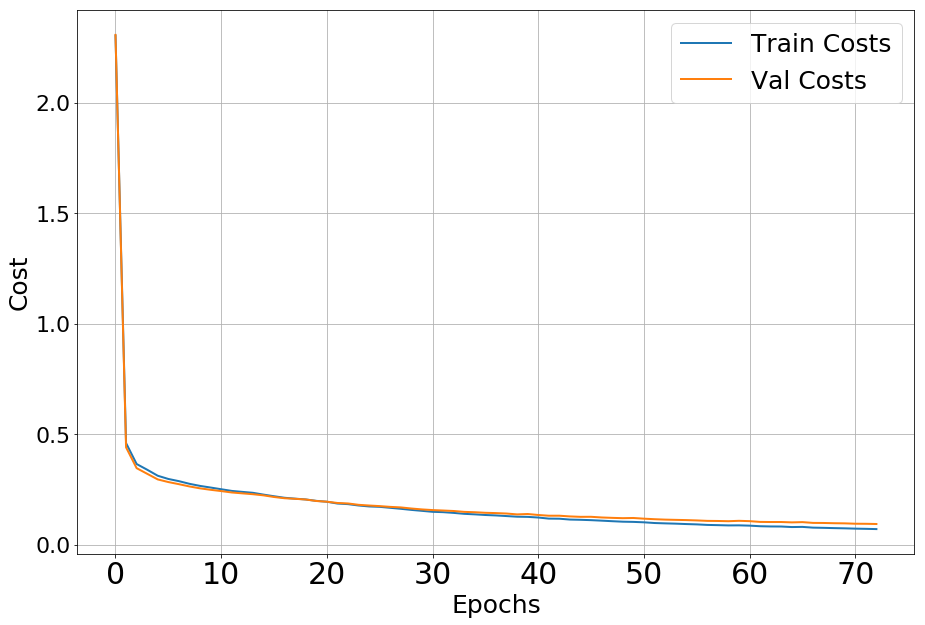

In [11]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

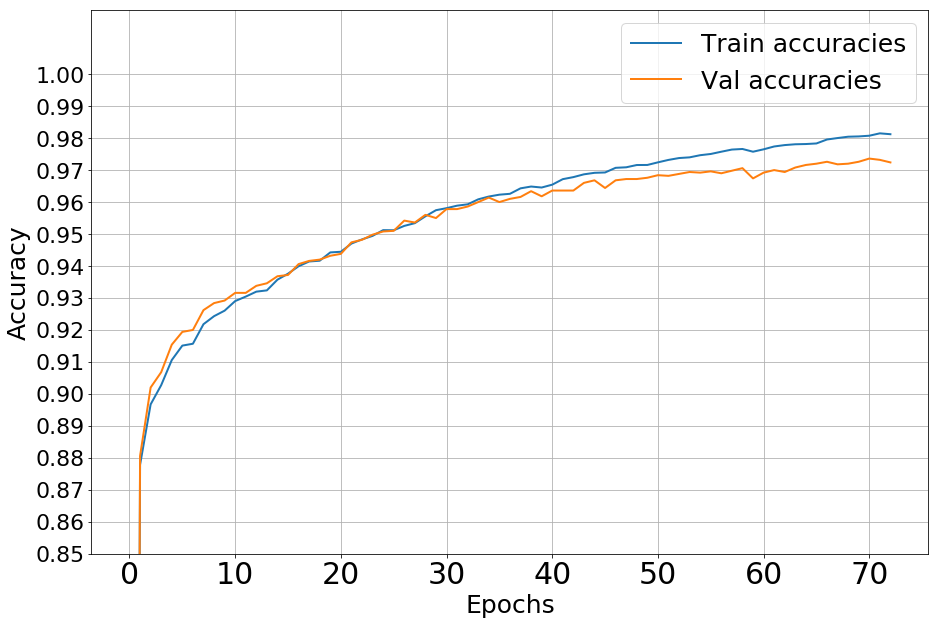

In [13]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.85,1.02)
plt.grid()
plt.legend()
plt.show()

## Feedback alignment (Random backprop or FA)

In [14]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [15]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    w_2_r = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2_r')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    #w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    #w_3_r = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_r')
    w_3_r = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3_r')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    d_z_3 = tf.gradients(cost,z_3)[0]
    d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    d_w_3 = tf.gradients(cost,w_3, name='delta_w3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    ### random backprop (NOTICE THAT WE'RE USING A FIXED RANDOM MATRIX w_3_r TO CALCULATE d_z_2 (delta2))
    #d_z_2_r = tf.multiply(tf.matmul(tf.transpose(w_3_r),d_z_3, name = 'w_3_rTxdelta3'), sigmaprime(z_2), 
    #                      name = 'delta2_r')
    d_z_2_r = tf.multiply(tf.matmul(tf.transpose(w_3_r),d_z_3, name = 'w_3_rTxdelta3'), tf.gradients(a_2,z_2)[0], 
                          name = 'delta2_r')
    d_b_2_r = d_z_2_r
    d_w_2_r = tf.matmul(d_z_2_r,tf.transpose(a_1), name = 'delta_w2_r')

step_r = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_r)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_r, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [16]:
train_accuracies_r = []
train_costs_r = []
val_accuracies_r = []
val_costs_r = []
best_val_r = 0
best_params_r = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_r, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_r.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_r.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_r.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_r.append(val_acc / 5000.0)
        if(val_acc>best_val_r):
            best_val_r = val_acc
            best_params_r = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_r[0][0]), tf.assign(b_2,best_params_r[0][1]),tf.assign(w_3,best_params_r[1][0]),\
    tf.assign(b_3,best_params_r[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.31225442886 and training accuracy:0.117963636364
validation cost:2.30948019028 and validation accuracy:0.1262
Epoch:1
training cost:0.517924726009 and training accuracy:0.868309090909
validation cost:0.497923970222 and validation accuracy:0.8748
Epoch:2
training cost:0.430952340364 and training accuracy:0.8826
validation cost:0.410992592573 and validation accuracy:0.8884
Epoch:3
training cost:0.393776446581 and training accuracy:0.8902
validation cost:0.372431486845 and validation accuracy:0.898
Epoch:4
training cost:0.370260179043 and training accuracy:0.896490909091
validation cost:0.350831627846 and validation accuracy:0.9028
Epoch:5
training cost:0.355072438717 and training accuracy:0.901472727273
validation cost:0.335105419159 and validation accuracy:0.909
Epoch:6
training cost:0.347041577101 and training accuracy:0.901963636364
validation cost:0.326935559511 and validation accuracy:0.9094
Epoch:7
training cost:0.334867328405 and training accuracy:0.9060909

Epoch:61
training cost:0.24598146975 and training accuracy:0.930563636364
validation cost:0.243072018027 and validation accuracy:0.9302
Epoch:62
training cost:0.24429371953 and training accuracy:0.931527272727
validation cost:0.241939887404 and validation accuracy:0.933
Epoch:63
training cost:0.244462504983 and training accuracy:0.931818181818
validation cost:0.242139384151 and validation accuracy:0.9328
Epoch:64
training cost:0.244102805853 and training accuracy:0.931163636364
validation cost:0.2414932549 and validation accuracy:0.9316
Epoch:65
training cost:0.242174774408 and training accuracy:0.932145454545
validation cost:0.240468606353 and validation accuracy:0.9332
Epoch:66
training cost:0.240804091096 and training accuracy:0.931854545455
validation cost:0.239019796252 and validation accuracy:0.9322
Epoch:67
training cost:0.242365807295 and training accuracy:0.931563636364
validation cost:0.240669429302 and validation accuracy:0.9328
Epoch:68
training cost:0.241893664002 and trai

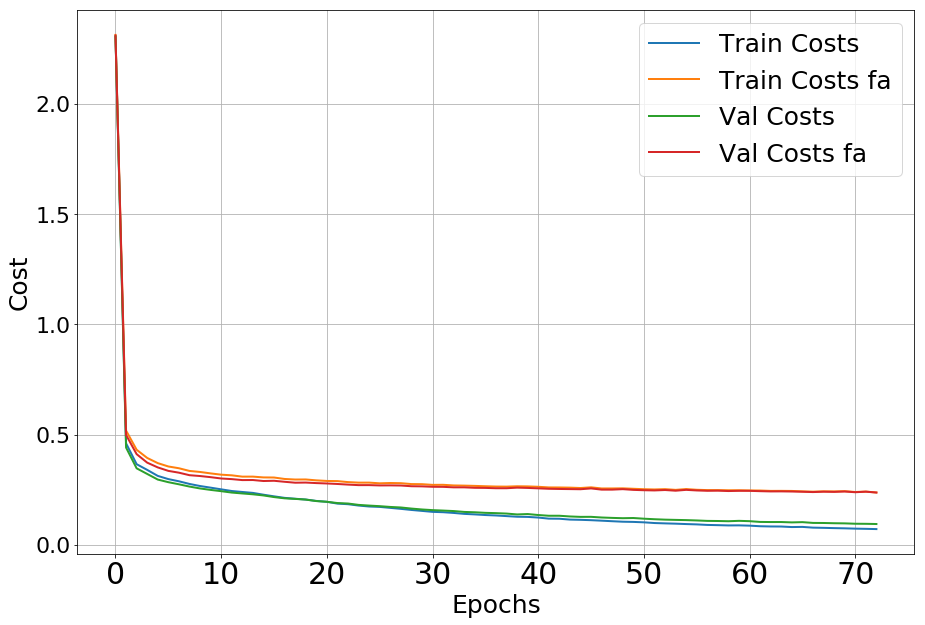

In [17]:
plt.plot(train_costs, label="Train Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs, label="Val Costs")
plt.plot(val_costs_r, label="Val Costs fa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

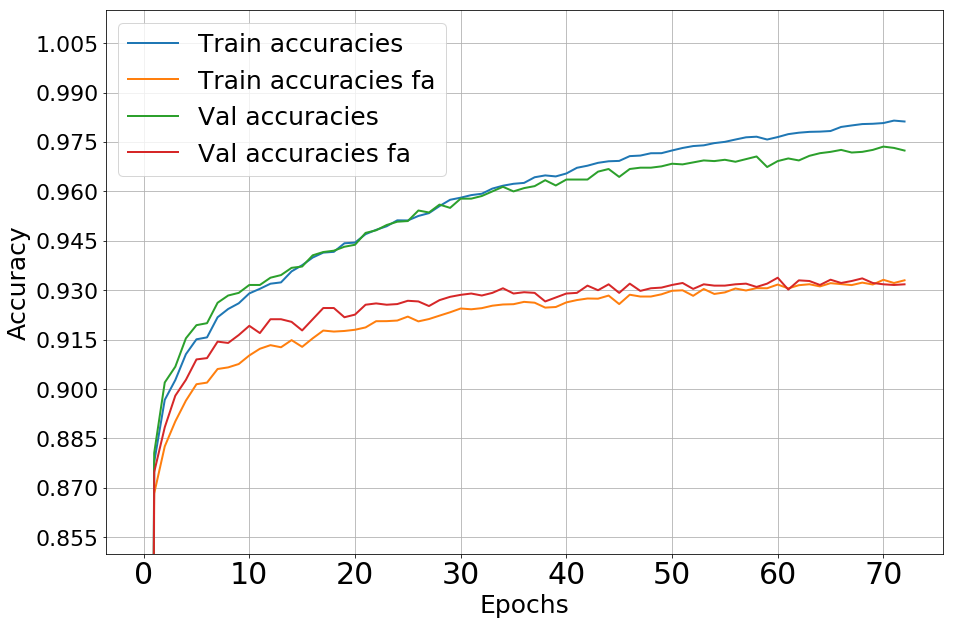

In [19]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies, label="Val accuracies")
plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,80)])
plt.ylim(0.85,1.015)
plt.grid()
plt.legend()
plt.show()

## Direct feedback alignment (DFA)

In [20]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [22]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    low_df = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high_df = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_2_df = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low_df,maxval=high_df), name = 'W_2_df')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    #w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    #w_3_df = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_df')
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    w_3_df = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3_df')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))


with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    d_z_3 = tf.gradients(cost,z_3)[0]
    d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    d_w_3 = tf.gradients(cost,w_3, name='delta_w3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    #d_z_2_df = tf.multiply(tf.matmul(tf.transpose(w_2_df),d_z_3, name = 'w_2_dfTxdelta3'), sigmaprime(z_2), 
    #                      name = 'delta2_df') #<-- DIRECT FEEDBACK FROM OP LAYER
    d_z_2_df = tf.multiply(tf.matmul(tf.transpose(w_2_df),d_z_3, name = 'w_3_dfTxdelta3'), tf.gradients(a_2,z_2)[0], 
                          name = 'delta2_df') #<-- DIRECT FEEDBACK FROM OP LAYER
    
    d_b_2_df = d_z_2_df
    d_w_2_df = tf.matmul(d_z_2_df,tf.transpose(a_1), name = 'delta_w2_df')

step_df = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_df)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_df, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [23]:
train_accuracies_df = []
train_costs_df = []
val_accuracies_df = []
val_costs_df = []
best_val_df = 0
best_params_df = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_df, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_df.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_df.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_df.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_df.append(val_acc / 5000.0)
        if(val_acc>best_val_df):
            best_val_df = val_acc
            best_params_df = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_df[0][0]), tf.assign(b_2,best_params_df[0][1]),tf.assign(w_3,best_params_df[1][0]),\
    tf.assign(b_3,best_params_df[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.30993270874 and training accuracy:0.0968363636364
validation cost:2.31041550636 and validation accuracy:0.0948
Epoch:1
training cost:0.434582948685 and training accuracy:0.8842
validation cost:0.412671715021 and validation accuracy:0.892
Epoch:2
training cost:0.364121377468 and training accuracy:0.895290909091
validation cost:0.343503177166 and validation accuracy:0.9048
Epoch:3
training cost:0.328379690647 and training accuracy:0.906509090909
validation cost:0.309266984463 and validation accuracy:0.9122
Epoch:4
training cost:0.307082533836 and training accuracy:0.912418181818
validation cost:0.291206359863 and validation accuracy:0.917
Epoch:5
training cost:0.291553109884 and training accuracy:0.916381818182
validation cost:0.276227653027 and validation accuracy:0.9234
Epoch:6
training cost:0.280445724726 and training accuracy:0.918963636364
validation cost:0.265536218882 and validation accuracy:0.9266
Epoch:7
training cost:0.266632020473 and training accuracy:

Epoch:61
training cost:0.0864022374153 and training accuracy:0.976163636364
validation cost:0.104879982769 and validation accuracy:0.9698
Epoch:62
training cost:0.0850821733475 and training accuracy:0.9768
validation cost:0.103278748691 and validation accuracy:0.9702
Epoch:63
training cost:0.0837475657463 and training accuracy:0.977618181818
validation cost:0.103244058788 and validation accuracy:0.972
Epoch:64
training cost:0.084014095366 and training accuracy:0.977363636364
validation cost:0.102791406214 and validation accuracy:0.9712
Epoch:65
training cost:0.083812944591 and training accuracy:0.976872727273
validation cost:0.10301707685 and validation accuracy:0.9694
Epoch:66
training cost:0.0806984379888 and training accuracy:0.978236363636
validation cost:0.100378744304 and validation accuracy:0.9718
Epoch:67
training cost:0.0832308381796 and training accuracy:0.976927272727
validation cost:0.102428503335 and validation accuracy:0.9716
Epoch:68
training cost:0.079130679369 and trai

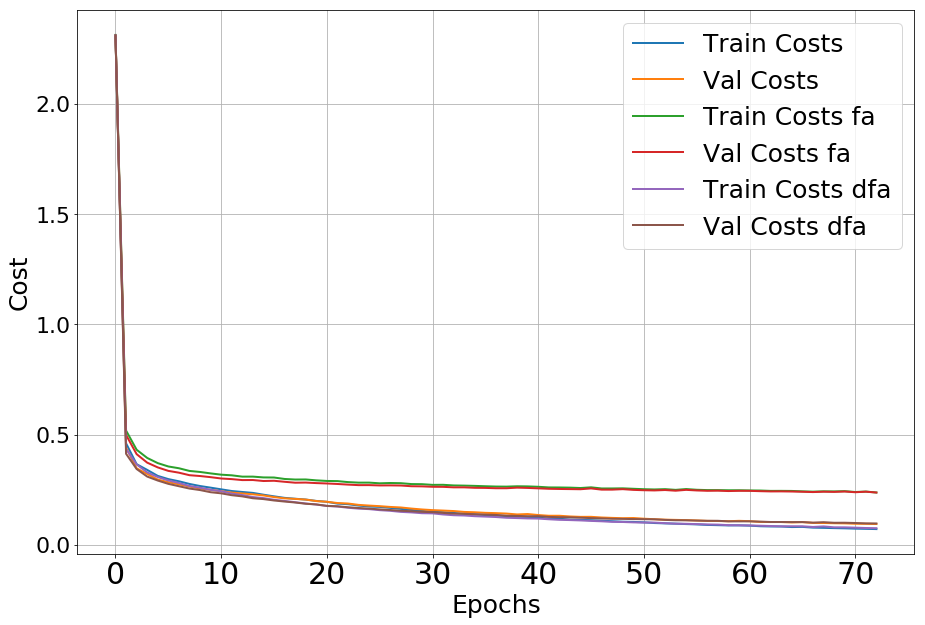

In [24]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs_r, label="Val Costs fa")
plt.plot(train_costs_df, label="Train Costs dfa")
plt.plot(val_costs_df, label="Val Costs dfa")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

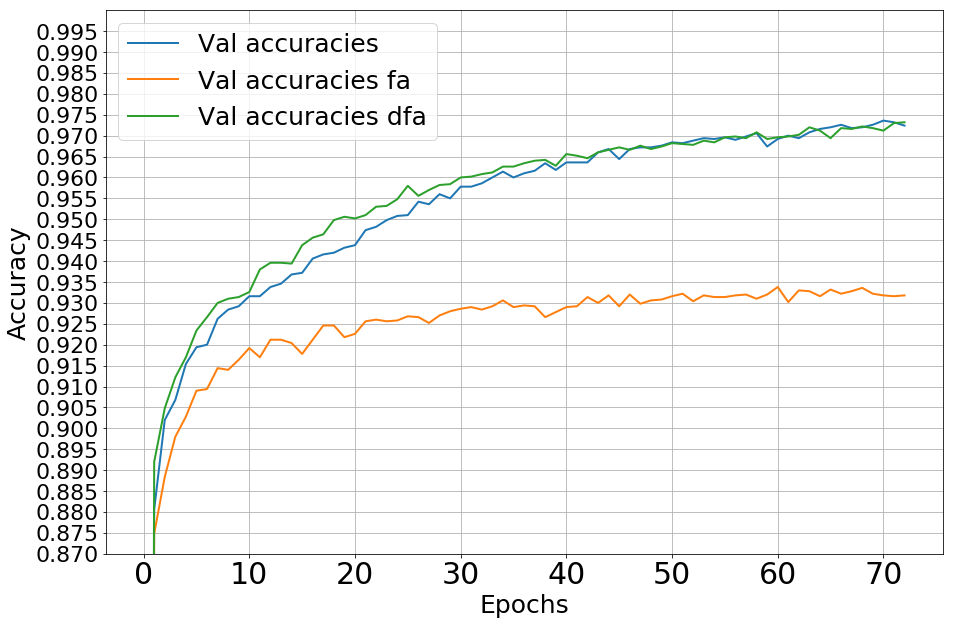

In [26]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
#plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(train_accuracies_df, label="Train accuracies dfa")
plt.plot(val_accuracies_df, label="Val accuracies dfa")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.005*i for i in range(1,200)])
plt.ylim(0.87,1.0)
plt.grid()
plt.legend()
plt.show()

## Feedforward updates (FF)


In [ ]:
sess.close()
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [27]:
a_1 = tf.placeholder(tf.float32, [784, None], name = 'Input_batch')
y = tf.placeholder(tf.float32, [10, None], name = 'output_batch')

with tf.name_scope('hidden_layer'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(784 + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(784 + n_middle))
    w_2 = tf.Variable(tf.random_uniform(shape=[n_middle,784],minval=low,maxval=high), name = 'W_2')
    low_ff = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high_ff = 4*tf.math.sqrt(6.0/(n_middle + 10))
    w_2_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low_df,maxval=high_df), name = 'W_2_df')
    b_2 = tf.Variable(tf.zeros([n_middle,1]), name = 'b_2')
with tf.name_scope('output_layer'):
    low = -4*tf.math.sqrt(6.0/(n_middle + 10)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_middle + 10))
    #w_3 = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3')
    #w_3_ff = tf.Variable(tf.random_uniform(shape=[10,n_middle],minval=low,maxval=high), name = 'W_3_df')
    w_3 = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3')
    w_3_ff = tf.Variable(tf.truncated_normal(shape=[10,n_middle], stddev=0.01),name = 'W_3_ff')
    b_3 = tf.Variable(tf.zeros([10,1]), name = 'b_3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))


with tf.name_scope('hidden_lyr_ffwd'):
    z_2 = tf.add(tf.matmul(w_2,a_1,name = 'w_2xa_1'), b_2, name = 'z_2')
    a_2 = sigma(z_2)
with tf.name_scope('op_lyr_ffwd'):
    z_3 = tf.add(tf.matmul(w_3,a_2, name = 'w_3xa_2'),b_3, name = 'z_3')
    a_3 = tf.nn.softmax(z_3,axis=0) ##AXIS IS VERY IMPORTANT!!! axis=0 INDICATES THE CLASSES AS y IS [10,None]
    #a_3  = sigma(z_3) UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT SIGMOID SQUISHING

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=z_3,axis=0),name = 'cost_calc')#WORKS


with tf.name_scope('bprop_op_lyr'):
    #d_z_3 = -tf.subtract(y,a_3, name = 'delta3')
    d_z_3 = tf.gradients(cost,z_3,name = 'delta3')[0]
    d_b_3 = d_z_3
    #d_w_3 = tf.matmul(d_z_3,tf.transpose(a_2), name='delta_w3')
    d_w_3 = tf.gradients(cost,w_3, name='delta_w3')[0]
    
with tf.name_scope('bprop_hidden_lyr'):
    d_z_2_ff = tf.multiply(tf.matmul(tf.transpose(w_2_ff),y, name = 'w_2_ffTxy'), sigmaprime(z_2), 
                          name = 'delta2_ff') #<-- NOTICE THAT WE'RE USING LABELS!! AND NOT THE ERRORS FROM 
                                            # TOWARDS THE OUTPUT DIRECTION
    d_b_2_ff = d_z_2_ff
    d_w_2_ff = tf.matmul(d_z_2_ff,tf.transpose(a_1), name = 'delta_w2_ff')

step_ff = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/batch_size, d_w_2_ff)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2_ff, axis=[1]),axis=-1))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/batch_size, d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[1]),axis=-1))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 0), tf.argmax(y, 0))
    acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

init_op = tf.global_variables_initializer()
sess.run(init_op,options=run_options, run_metadata=run_metadata)

In [28]:
train_accuracies_ff = []
train_costs_ff = []
val_accuracies_ff = []
val_costs_ff = []
best_val_ff = 0
best_params_ff = None
for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.transpose()
    batch_ys = batch_ys.transpose()
    #print(batch_xs.shape, batch_ys.shape)
    sess.run(step_ff, feed_dict = {a_1: batch_xs,
                y : batch_ys}, options=run_options,run_metadata=run_metadata)
    
    if((i*batch_size) % (mnist.train.images.shape[0]) == 0):
        print('Epoch:{}'.format((i*batch_size / mnist.train.images.shape[0])))
        train_cost = sess.run(cost, feed_dict = {a_1 : mnist.train.images.transpose(),
                                                y : mnist.train.labels.transpose()} )
        train_costs_ff.append(train_cost)
        train_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.train.images.transpose(),
                        y : mnist.train.labels.transpose()})
        train_accuracies_ff.append(train_acc / 55000.0)
        print('training cost:{} and training accuracy:{}'.format(train_cost, train_acc / 55000.0))
        
        val_cost = sess.run(cost, feed_dict = {a_1 : mnist.validation.images.transpose(),
                                                y : mnist.validation.labels.transpose()} )
        val_costs_ff.append(val_cost)
        val_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.validation.images.transpose(),
                        y : mnist.validation.labels.transpose()})
        val_accuracies_ff.append(val_acc / 5000.0)
        if(val_acc>best_val_ff):
            best_val_ff = val_acc
            best_params_ff = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc / 5000.0))
        
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Final test accuracy is:{}'.format(test_acc / 10000.0))

best_step = [tf.assign(w_2,best_params_ff[0][0]), tf.assign(b_2,best_params_ff[0][1]),tf.assign(w_3,best_params_ff[1][0]),\
    tf.assign(b_3,best_params_ff[1][1])]

sess.run(best_step)
test_acc = sess.run(acct_res, feed_dict =
                       {a_1: mnist.test.images.transpose(),
                        y : mnist.test.labels.transpose()})
print('Test accuracy corresp to best val acc:{}'.format(test_acc / 10000.0))

Epoch:0
training cost:2.31011724472 and training accuracy:0.0979818181818
validation cost:2.31241130829 and validation accuracy:0.0924
Epoch:1
training cost:0.356461375952 and training accuracy:0.888818181818
validation cost:0.336762428284 and validation accuracy:0.8992
Epoch:2
training cost:0.293244361877 and training accuracy:0.909272727273
validation cost:0.27318456769 and validation accuracy:0.9178
Epoch:3
training cost:0.269647419453 and training accuracy:0.915781818182
validation cost:0.251183152199 and validation accuracy:0.9244
Epoch:4
training cost:0.250231087208 and training accuracy:0.922781818182
validation cost:0.235499367118 and validation accuracy:0.9294
Epoch:5
training cost:0.239072084427 and training accuracy:0.926818181818
validation cost:0.222938895226 and validation accuracy:0.932
Epoch:6
training cost:0.229826405644 and training accuracy:0.929090909091
validation cost:0.216515213251 and validation accuracy:0.9322
Epoch:7
training cost:0.219123750925 and training a

Epoch:61
training cost:0.117493197322 and training accuracy:0.963181818182
validation cost:0.143150895834 and validation accuracy:0.9594
Epoch:62
training cost:0.118200905621 and training accuracy:0.962818181818
validation cost:0.144792333245 and validation accuracy:0.9588
Epoch:63
training cost:0.115554854274 and training accuracy:0.963327272727
validation cost:0.14115729928 and validation accuracy:0.9582
Epoch:64
training cost:0.11577116698 and training accuracy:0.963436363636
validation cost:0.141313374043 and validation accuracy:0.9578
Epoch:65
training cost:0.11646297574 and training accuracy:0.963545454545
validation cost:0.141213983297 and validation accuracy:0.9604
Epoch:66
training cost:0.115961559117 and training accuracy:0.964018181818
validation cost:0.144336655736 and validation accuracy:0.9578
Epoch:67
training cost:0.11520037055 and training accuracy:0.963636363636
validation cost:0.142513483763 and validation accuracy:0.9588
Epoch:68
training cost:0.114089347422 and tra

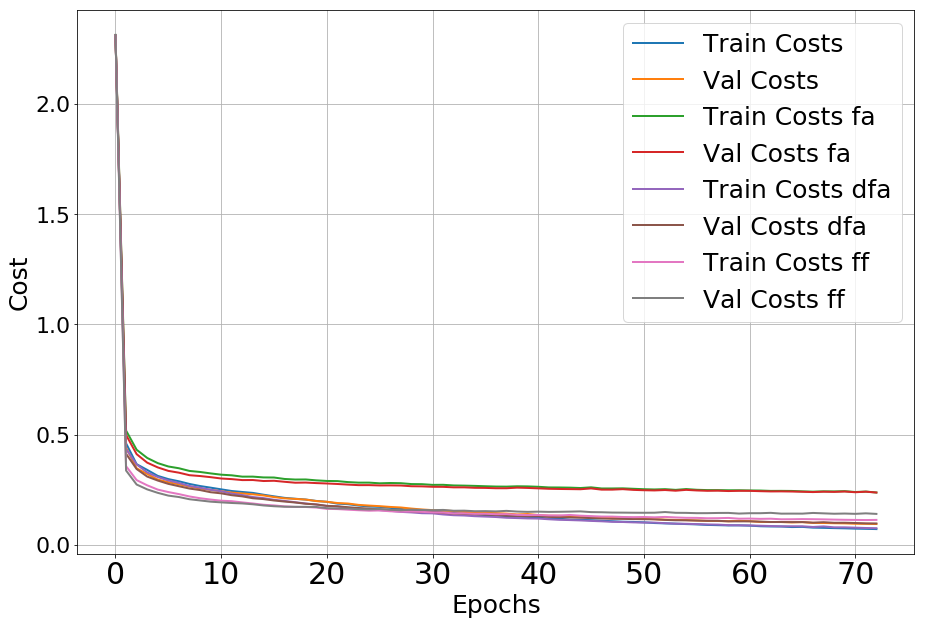

In [29]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.plot(train_costs_r, label="Train Costs fa")
plt.plot(val_costs_r, label="Val Costs fa")
plt.plot(train_costs_df, label="Train Costs dfa")
plt.plot(val_costs_df, label="Val Costs dfa")
plt.plot(train_costs_ff, label="Train Costs ff")
plt.plot(val_costs_ff, label="Val Costs ff")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

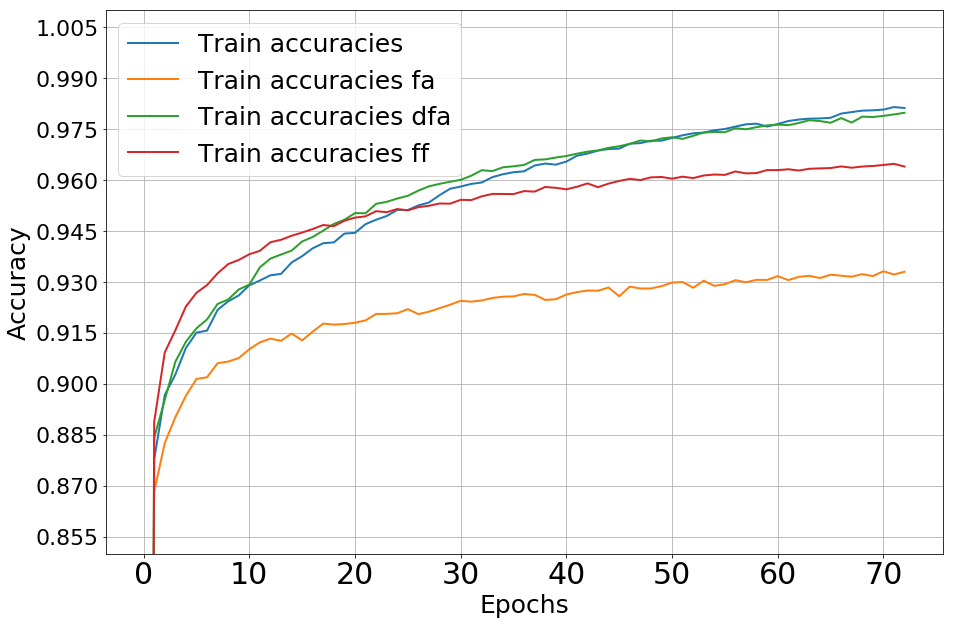

In [30]:
plt.plot(train_accuracies, label="Train accuracies")
#plt.plot(val_accuracies, label="Val accuracies")
plt.plot(train_accuracies_r, label="Train accuracies fa")
#plt.plot(val_accuracies_r, label="Val accuracies fa")
plt.plot(train_accuracies_df, label="Train accuracies dfa")
#plt.plot(val_accuracies_df, label="Val accuracies dfa")
plt.plot(train_accuracies_ff, label="Train accuracies ff")
#plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,95)])
plt.ylim(0.85,1.01)
plt.grid()
plt.legend()
plt.show()

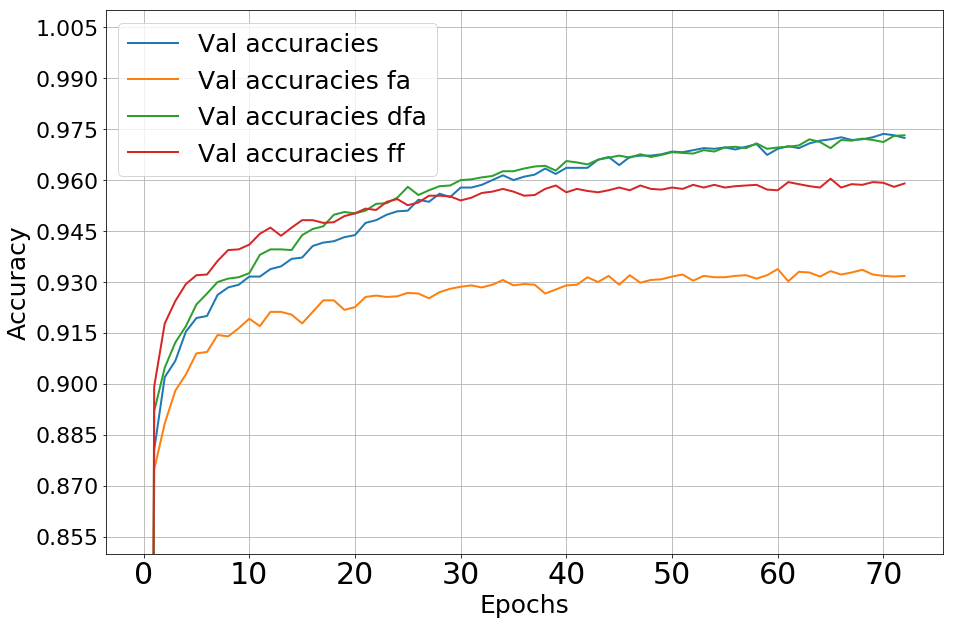

In [31]:
#plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
#plt.plot(train_accuracies_r, label="Train accuracies fa")
plt.plot(val_accuracies_r, label="Val accuracies fa")
#plt.plot(train_accuracies_df, label="Train accuracies dfa")
plt.plot(val_accuracies_df, label="Val accuracies dfa")
#plt.plot(train_accuracies_ff, label="Train accuracies ff")
plt.plot(val_accuracies_ff, label="Val accuracies ff")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.015*i for i in range(1,95)])
plt.ylim(0.85,1.01)
plt.grid()
plt.legend()
plt.show()

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()